In [16]:
import numpy as np
import pandas as pd
import os
import cv2

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# alias path to train images
train_images = []
for image in os.listdir("train"):
    path = "train/" + image
    train_images.append(path)


In [3]:
len(train_images)

109237

In [4]:
# read in train csv file
photo_attribute_ids_map = pd.read_csv('train_.csv')
photo_attribute_ids_map.head()

,photo_id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [5]:
# create a target vector for each image
# the attribute_ids must be turned into a list

photo_attribute_ids_map["attribute_ids"] = photo_attribute_ids_map["attribute_ids"].apply(lambda x: x.split(" "))
photo_attribute_ids_map["photo_id"] = photo_attribute_ids_map["photo_id"].apply(lambda x: x+".png")
photo_attribute_ids_map.head()

,photo_id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


In [6]:
# read in label csv file
attributeId_attributeName_map = pd.read_csv('labels.csv')
attributeId_attributeName_map.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


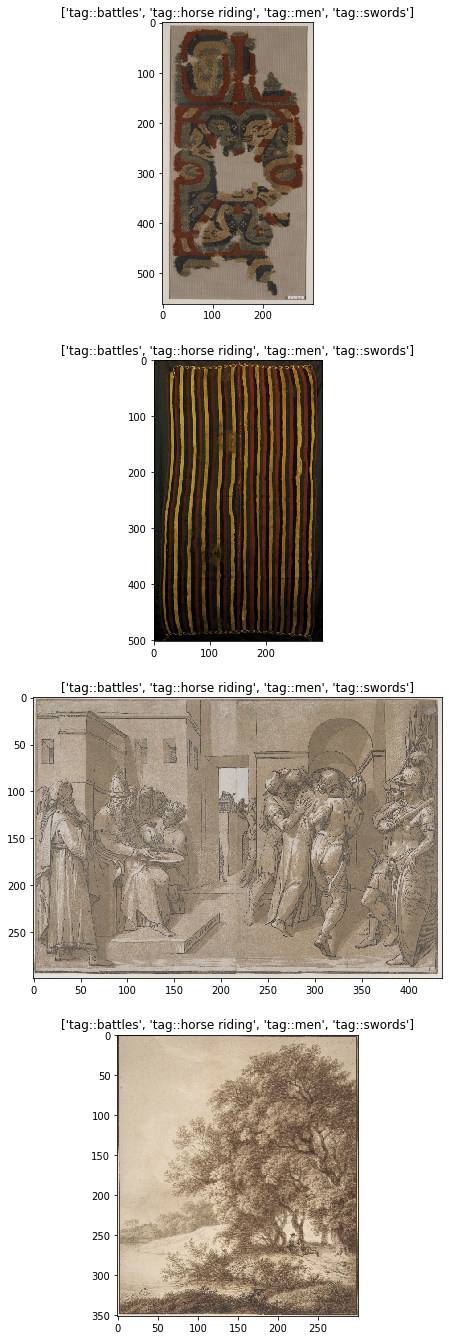

In [7]:
# preview a few images

i = 1
plt.figure(figsize=[30,30])
for img_name in os.listdir("train")[6:10]:   
    img = cv2.imread("train/%s" % img_name)[...,[2, 1, 0]]
    
    plt.subplot(5, 1, i)
    plt.imshow(img)
    ids = photo_attribute_ids_map[photo_attribute_ids_map["photo_id"] == image]["attribute_ids"]
    title_val = []
    for tag_id in ids.values[0]:
        att_name = attributeId_attributeName_map[attributeId_attributeName_map['attribute_id'].astype(str) == tag_id]['attribute_name'].values[0]
        title_val.append(att_name)
    plt.title(title_val)
    i += 1
    
plt.show()

In [8]:
type(train_images)

list

In [9]:
file_count_train = os.listdir('train')
print(f"file count in train: {len(file_count_train)}")

file_count_test = os.listdir('test')
print(f"file count in test: {len(file_count_test)}")

file count in train: 109237
file count in test: 38801


Kaggle does not provide targets for test set so I will split the train dataset between train and test so I can evaluate my model.

In [11]:
ImDatGen=ImageDataGenerator(
    rescale=1./255,            # standardize the data to reduce compute time
    validation_split=0.25,     # split data between train and test
    #horizontal_flip = True,    
    #zoom_range = 0.3,
    #width_shift_range = 0.3,
    #height_shift_range=0.3
    )

In [19]:
generator = ImDatGen.flow_from_dataframe(
    dataframe=photo_attribute_ids_map,
    directory='train',
    x_col='photo_id',
    y_col='attribute_ids',
    class_mode = 'other', # ***
    target_size=(75, 75),
    batch_size=32 
)

Found 109163 validated image filenames.


In [14]:
generator.next()

(array([[[[0.6862745 , 0.6666667 , 0.6509804 ],
          [0.6784314 , 0.65882355, 0.6431373 ],
          [0.6862745 , 0.6666667 , 0.6509804 ],
          ...,
          [0.67058825, 0.6509804 , 0.63529414],
          [0.6784314 , 0.65882355, 0.6431373 ],
          [0.6784314 , 0.65882355, 0.6431373 ]],
 
         [[0.6862745 , 0.6666667 , 0.6431373 ],
          [0.6862745 , 0.6666667 , 0.6509804 ],
          [0.6901961 , 0.67058825, 0.64705884],
          ...,
          [0.6666667 , 0.64705884, 0.6313726 ],
          [0.68235296, 0.6627451 , 0.6392157 ],
          [0.6784314 , 0.65882355, 0.63529414]],
 
         [[0.6901961 , 0.67058825, 0.64705884],
          [0.69411767, 0.6745098 , 0.6509804 ],
          [0.68235296, 0.6627451 , 0.6392157 ],
          ...,
          [0.6666667 , 0.64705884, 0.62352943],
          [0.6862745 , 0.6666667 , 0.6431373 ],
          [0.6745098 , 0.654902  , 0.6313726 ]],
 
         ...,
 
         [[0.63529414, 0.61960787, 0.58431375],
          [0.61568

In [18]:
model = Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(75 ,75,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [22]:
train_model = model.fit('train',
                    photo_attribute_ids_map["attribute_ids"],
                    epochs=50,
                    batch_size=32)
                    #validation_data=(val, label_val)
                       

AttributeError: 'str' object has no attribute 'ndim'